In [1]:
#| code-summary: Load packages
#| code-fold: true

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7  # max number of rows to display

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# For high resolution display
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [2]:
#| echo: false
pd.options.display.notebook_repr_html = False

## Song rankings for Billboard top 100 in the year 2000
"billboard" in a package "tidyr"  
Source: [The Whitburn Project](https://waxy.org/2008/05/the_whitburn_project/)

다음 링크의 데이터는 빌보드차트에 관한 데이터입니다; [링크](https://www.dropbox.com/s/svkuflje8fesv2a/billboard.csv?dl=1) 


- 각 곡이 차트에 진입한 날짜(`date_entered`)인 첫주(`wk1`)의 순위부터 78주(`wk78`)의 순위까지 기록되어 있습니다. 
- 차트에서 빠진 경우 missing (NA)으로 표시되어 있습니다.  
- 빌보드의 정책과 데이터 추출에 대해서 분명하지 않기 때문에 정확한 분석은 아닐 수 있습니다.
  - 예를 들어, 20주 연속 차트에 있거나, 50위 밖으로 밀려난 경우 차트에서 제거된다고 합니다.

In [3]:
billboard = pd.read_csv("data/billboard.csv")
billboard.head(5)

         artist                    track date_entered  wk1   wk2   wk3   wk4  \
0         2 Pac  Baby Don't Cry (Keep...   2000-02-26   87 82.00 72.00 77.00   
1       2Ge+her  The Hardest Part Of ...   2000-09-02   91 87.00 92.00   NaN   
2  3 Doors Down               Kryptonite   2000-04-08   81 70.00 68.00 67.00   
3  3 Doors Down                    Loser   2000-10-21   76 76.00 72.00 69.00   
4      504 Boyz            Wobble Wobble   2000-04-15   57 34.00 25.00 17.00   

    wk5   wk6   wk7  ...  wk67  wk68  wk69  wk70  wk71  wk72  wk73  wk74  \
0 87.00 94.00 99.00  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2 66.00 57.00 54.00  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3 67.00 65.00 55.00  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4 17.00 31.00 36.00  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   wk75  wk76  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN 

1. 총 몇 명의 가수(`artist`)가 차트에 있으며, 가수별로 몇 곡(`track`)이 차트에 들어있는지 알아보세요. (동명이인은 없다고 가정하고)

In [4]:
billboard.value_counts("artist")

artist
Jay-Z                5
Houston, Whitney     4
Dixie Chicks, The    4
                    ..
Hollister, Dave      1
Hot Boys             1
matchbox twenty      1
Name: count, Length: 228, dtype: int64

2. 곡명은 같지만, 가수가 다른 곡이 있는지 알아보고, 서로 다른 노래가 차트에 몇 개나 있는지 알아보세요.

In [5]:
billboard.value_counts("track")

track
Where I Wanna Be      2
Original Prankster    1
Separated             1
                     ..
He Loves U Not        1
He Can't Love U       1
www.memory            1
Name: count, Length: 316, dtype: int64

3. 이 데이터를 주(week)에 대해서 아래처럼 long format으로 바꿉니다.

In [9]:
billboard_long = (
    billboard
    .melt(id_vars=billboard.columns[:3], var_name="wk", value_name="rank")
    .sort_values(["artist", "track"])
)
billboard_long["wk"] = billboard_long["wk"].str.replace("wk", "").astype("int64")
billboard_long.dropna(subset="rank", inplace=True)

In [10]:
billboard_long

                artist                    track date_entered  wk  rank
0                2 Pac  Baby Don't Cry (Keep...   2000-02-26   1 87.00
317              2 Pac  Baby Don't Cry (Keep...   2000-02-26   2 82.00
634              2 Pac  Baby Don't Cry (Keep...   2000-02-26   3 72.00
...                ...                      ...          ...  ..   ...
11728  matchbox twenty                     Bent   2000-04-29  37 38.00
12045  matchbox twenty                     Bent   2000-04-29  38 38.00
12362  matchbox twenty                     Bent   2000-04-29  39 48.00

[5307 rows x 5 columns]

4. 50주 이상(포함) 머무른 곡들

In [11]:
wks_50 = (
    billboard_long.groupby(["artist", "track"], as_index=False)
    .size()
    .sort_values("size", ascending=False)
    .query("size >= 50")
)
wks_50

           artist       track  size
62          Creed      Higher    57
179      Lonestar      Amazed    55
121   Hill, Faith     Breathe    53
2    3 Doors Down  Kryptonite    53

5.1 먼저, 위 곡들만을 포함하도록 4번의 데이터와 원래 데이터(`billboard_long`)를 `merge()`를 이용해 추린 후, 50주 이상 머문 곡으로 필터링하세요.

In [12]:
wks_50_all =  billboard_long.merge(wks_50)
wks_50_all

           artist       track date_entered  wk  rank  size
0    3 Doors Down  Kryptonite   2000-04-08   1 81.00    53
1    3 Doors Down  Kryptonite   2000-04-08   2 70.00    53
2    3 Doors Down  Kryptonite   2000-04-08   3 68.00    53
..            ...         ...          ...  ..   ...   ...
215      Lonestar      Amazed   1999-06-05  62 42.00    55
216      Lonestar      Amazed   1999-06-05  63 45.00    55
217      Lonestar      Amazed   1999-06-05  64 50.00    55

[218 rows x 6 columns]

5.2 seaborn.objects를 이용해 대략 다음과 같이 주에 따른 순위의 변화를 그려보세요.

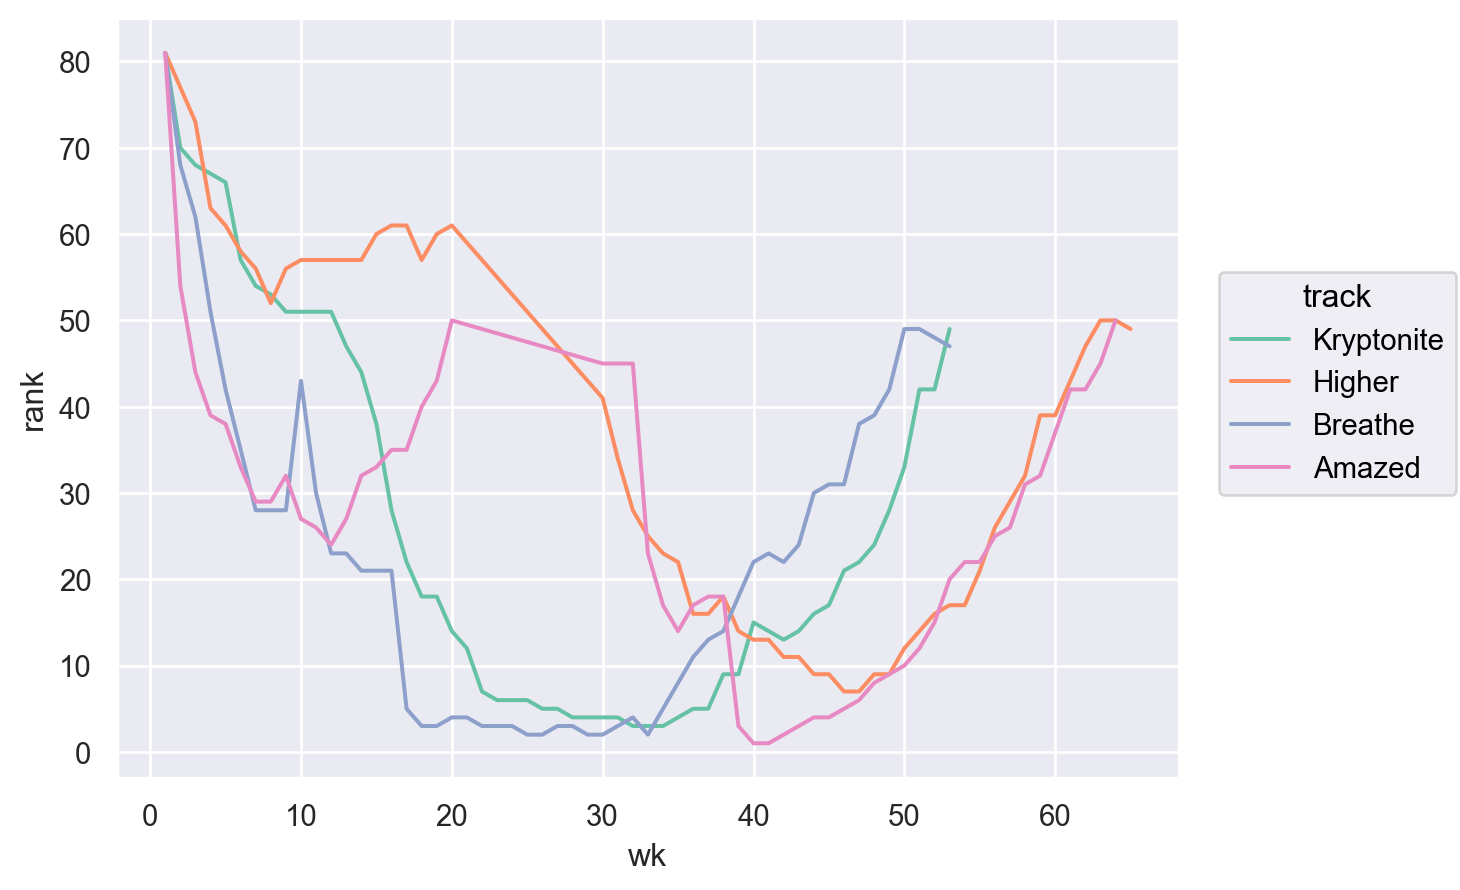

In [11]:
(
    so.Plot(wks_50_all, x="wk", y="rank", color="track")
    .add(so.Line())
    .scale(color="Set2")
)

6.1 곡별로 차트에 머문 기간을 포함한 데이터

In [13]:
lengths = (
    billboard_long
    .groupby(["artist", "track"])
    .size()
    .reset_index(name="length")
)
lengths

              artist                    track  length
0              2 Pac  Baby Don't Cry (Keep...       7
1            2Ge+her  The Hardest Part Of ...       3
2       3 Doors Down               Kryptonite      53
..               ...                      ...     ...
314  Ying Yang Twins  Whistle While You Tw...      14
315    Zombie Nation            Kernkraft 400       2
316  matchbox twenty                     Bent      39

[317 rows x 3 columns]

6.2 곡별로 최상위 순위를 `min()`을 이용해 구한 데이터를

In [14]:
highs = (
    billboard_long
    .groupby(["artist", "track"])["rank"]
    .min()
    .reset_index(name="high")
)
highs

              artist                    track  high
0              2 Pac  Baby Don't Cry (Keep... 72.00
1            2Ge+her  The Hardest Part Of ... 87.00
2       3 Doors Down               Kryptonite  3.00
..               ...                      ...   ...
314  Ying Yang Twins  Whistle While You Tw... 74.00
315    Zombie Nation            Kernkraft 400 99.00
316  matchbox twenty                     Bent  1.00

[317 rows x 3 columns]

6.3 `merge()`를 이용해 합친 후

In [15]:
lengths_highs = pd.merge(lengths, highs)
lengths_highs

              artist                    track  length  high
0              2 Pac  Baby Don't Cry (Keep...       7 72.00
1            2Ge+her  The Hardest Part Of ...       3 87.00
2       3 Doors Down               Kryptonite      53  3.00
..               ...                      ...     ...   ...
314  Ying Yang Twins  Whistle While You Tw...      14 74.00
315    Zombie Nation            Kernkraft 400       2 99.00
316  matchbox twenty                     Bent      39  1.00

[317 rows x 4 columns]

6.4 seaborn.objects를 이용해 머문 기간에 따른 최상위 순위에 대한 관계를 아래와 같이 scatterplot으로 살펴보세요.

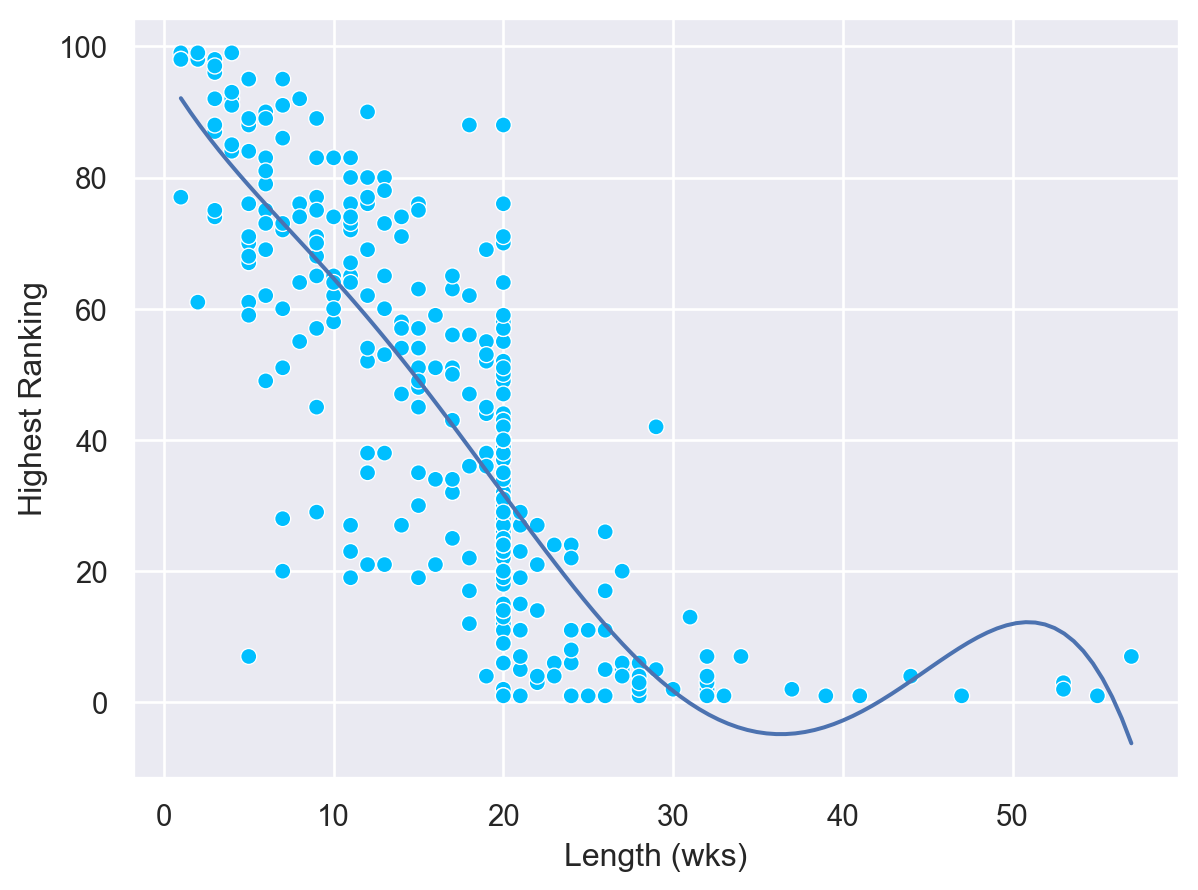

In [16]:
(
    so.Plot(lengths_highs, x="length", y="high")
    .add(so.Dot(color="deepskyblue", edgecolor="white"))
    .add(so.Line(), so.PolyFit(5))
    .label(x="Length (wks)", y="Highest Ranking")
)

7. 순위 1위를 달성한 곡들에 한해, 다음과 같이 차트에 진입시 순위와 1위에 처음 도달한 주(week)의 정보가 다음과 같이 표시되도록 구해보세요.
   - 함수를 만들고; `min()`과 `argmin()`이 필요할 수 있음
   - `apply()`로 그 함수를 적용하여 구해보세요.

In [49]:
def isranked(df, n=1):
    if df["rank"].min() == n:
        idx_rank = df["rank"].argmin()
        idx_wk = df["wk"].argmin()
        return df.iloc[[idx_wk, idx_rank], :] 

wk_rank = (
    billboard_long.groupby(["artist", "track"])[["rank", "wk"]]
    .apply(isranked)
    # .reset_index(level=[0, 1])
    # .reset_index().drop(columns="level_2")
)
wk_rank

                                                  rank  wk
artist              track                                 
Aaliyah             Try Again               8    59.00   1
                                            4129  1.00  14
Aguilera, Christina Come On Over Baby (A... 11   57.00   1
...                                                ...  ..
Vertical Horizon    Everything You Want     8225  1.00  26
matchbox twenty     Bent                    316  60.00   1
                                            4120  1.00  13

[34 rows x 2 columns]

In [50]:
# groupby filtering을 이용한 방법
(
    billboard_long.groupby(["artist", "track"])
    .filter(lambda x: x["rank"].min() == 1)  # groupby filtering
    .groupby(["artist", "track"])[["rank", "wk"]]
    .apply(lambda x: x.iloc[[x["wk"].argmin(), x["rank"].argmin()], -2:])
)

                                                  rank  wk
artist              track                                 
Aaliyah             Try Again               8    59.00   1
                                            4129  1.00  14
Aguilera, Christina Come On Over Baby (A... 11   57.00   1
...                                                ...  ..
Vertical Horizon    Everything You Want     8225  1.00  26
matchbox twenty     Bent                    316  60.00   1
                                            4120  1.00  13

[34 rows x 2 columns]

8. 빠르게 1위가 된 곡일 수록 빠르게 차트에서 사라졌을까를 알아보기 위해, 7번의 결과를 이용해 다음과 같이 변형해보세요.
   - 즉, 차트 진입시의 순위 정보와, 1위가 된 week의 정보만을 취해, 그 비율(rate)를 구하면, 얼마나 빠르게 1위가 되었는지 알 수 있습니다.

In [39]:
wk_rank.groupby(["artist", "track"]).max()

                                             rank  wk
artist              track                            
Aaliyah             Try Again               59.00  14
Aguilera, Christina Come On Over Baby (A... 57.00  11
                    What A Girl Wants       71.00   8
...                                           ...  ..
Sisqo               Incomplete              77.00   8
Vertical Horizon    Everything You Want     70.00  26
matchbox twenty     Bent                    60.00  13

[17 rows x 2 columns]

In [44]:
# 한 주에 몇 위 변동했는지 계산
rates = (
    wk_rank.groupby(["artist", "track"])
    .max()
    .assign(rate=lambda x: x["rank"] / x["wk"])
    .reset_index()
)
rates

                 artist                    track  rank  wk  rate
0               Aaliyah                Try Again 59.00  14  4.21
1   Aguilera, Christina  Come On Over Baby (A... 57.00  11  5.18
2   Aguilera, Christina        What A Girl Wants 71.00   8  8.88
..                  ...                      ...   ...  ..   ...
14                Sisqo               Incomplete 77.00   8  9.62
15     Vertical Horizon      Everything You Want 70.00  26  2.69
16      matchbox twenty                     Bent 60.00  13  4.62

[17 rows x 5 columns]

In [45]:
# 차트에 머무른 기간(주)
lengths = billboard_long.groupby(["artist", "track"]).size().reset_index(name="length")
lengths

              artist                    track  length
0              2 Pac  Baby Don't Cry (Keep...       7
1            2Ge+her  The Hardest Part Of ...       3
2       3 Doors Down               Kryptonite      53
..               ...                      ...     ...
314  Ying Yang Twins  Whistle While You Tw...      14
315    Zombie Nation            Kernkraft 400       2
316  matchbox twenty                     Bent      39

[317 rows x 3 columns]

In [46]:
lengths_rates = pd.merge(rates, lengths)
lengths_rates

                 artist                    track  rank  wk  rate  length
0               Aaliyah                Try Again 59.00  14  4.21      32
1   Aguilera, Christina  Come On Over Baby (A... 57.00  11  5.18      21
2   Aguilera, Christina        What A Girl Wants 71.00   8  8.88      24
..                  ...                      ...   ...  ..   ...     ...
14                Sisqo               Incomplete 77.00   8  9.62      26
15     Vertical Horizon      Everything You Want 70.00  26  2.69      41
16      matchbox twenty                     Bent 60.00  13  4.62      39

[17 rows x 6 columns]

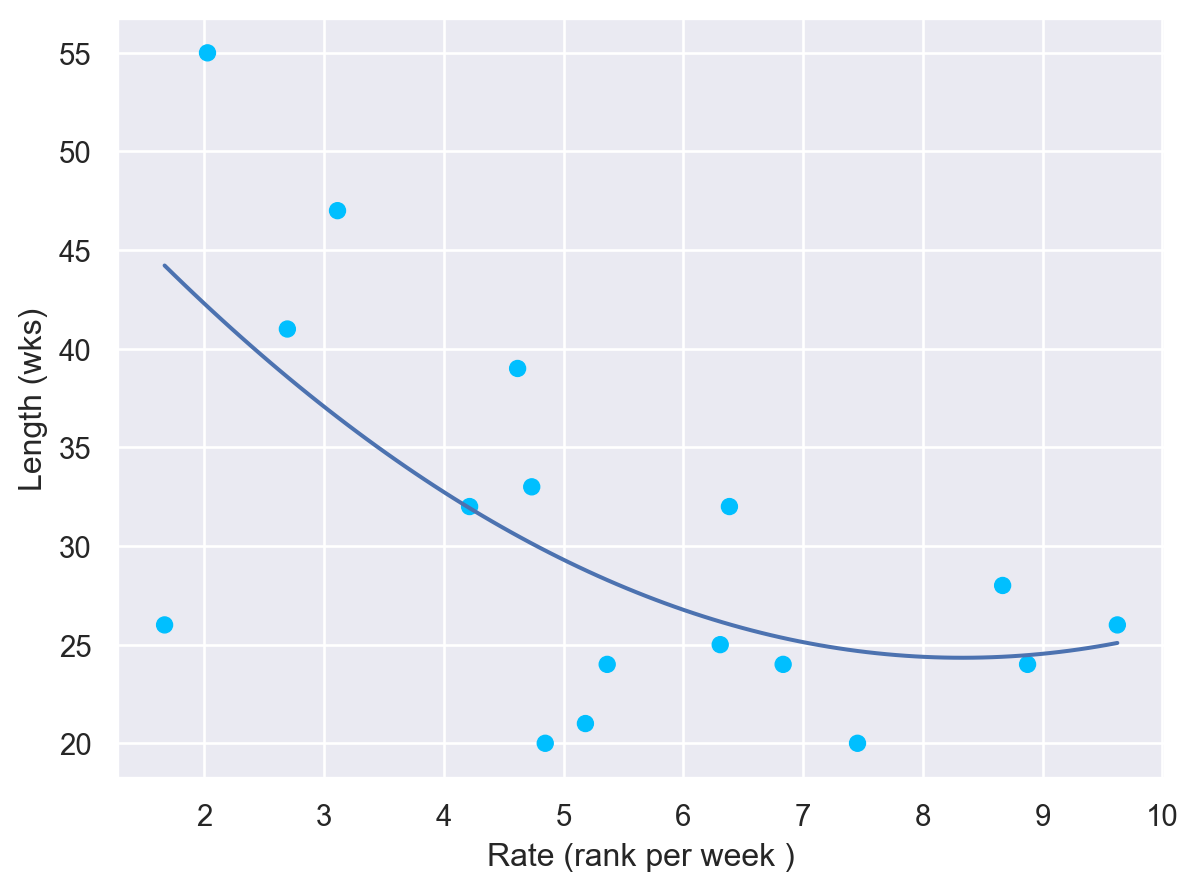

In [47]:
(
    so.Plot(lengths_rates, x="rate", y="length")
    .add(so.Dot(color="deepskyblue"))
    .add(so.Line(), so.PolyFit(2))
    .label(x="Rate (rank per week )", y="Length (wks)")
)